In [5]:
# Import libraries and cleaned seismic data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

seismic_data = pd.read_csv('cleaned_seismic.csv')
seismic_data.head()
print(seismic_data.columns)

Index(['Seismic Zone', 'PGA (m/s²)', 'PGV (m/s)', 'PGD (m)',
       'Spectral Acceleration (g)', 'Soil Type', 'Site Amplification Factor',
       'Historical Earthquake Magnitude (Mw)', 'Fault Distance (km)',
       'Seismic Wave Frequency (Hz)', 'Building Height (m)',
       'Number of Stories', 'Structural Material', 'Foundation Type',
       'Natural Frequency (Hz)', 'Damping Ratio (%)', 'Mass of Structure (kg)',
       'Axial Stiffness (kN/m)', 'Bending Stiffness (kN·m²)',
       'Lateral Load Resisting System',
       'Predicted Max Inter-Story Drift Ratio (%)',
       'Predicted Max Roof Displacement (m)',
       'Predicted Base Shear Force (kN)',
       'Predicted Structural Acceleration (m/s²)',
       'Predicted Damage Index (0–1 Scale)',
       'Predicted Collapse Probability (%)', 'damage_index', 'collapse_prob',
       'collapse_risk'],
      dtype='object')


## Feature Selection

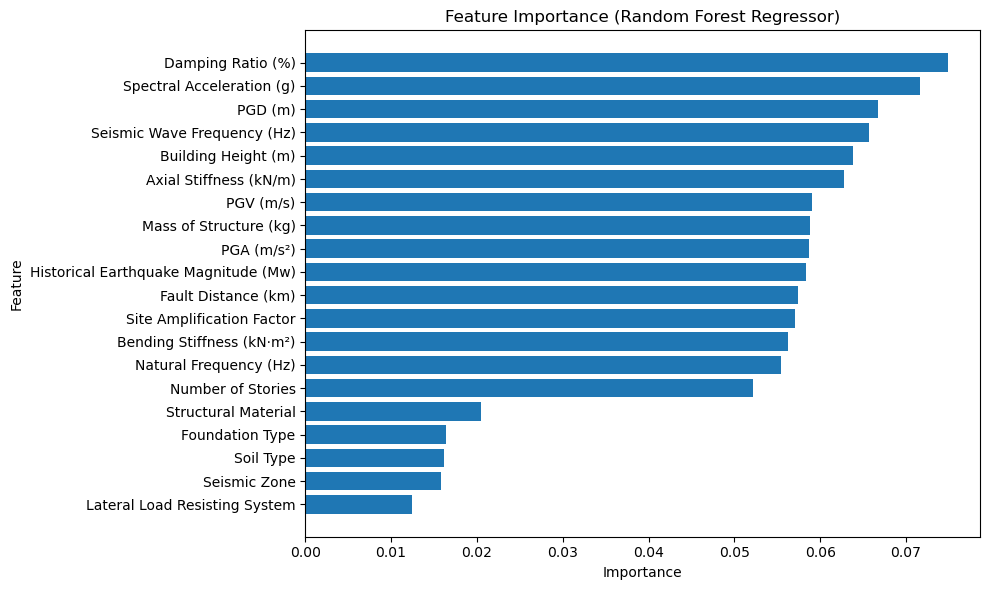

,Number of Stories,Natural Frequency (Hz),Bending Stiffness (kN·m²),Site Amplification Factor,Fault Distance (km),Historical Earthquake Magnitude (Mw),PGA (m/s²),Mass of Structure (kg),PGV (m/s),Axial Stiffness (kN/m),Building Height (m),Seismic Wave Frequency (Hz),PGD (m),Spectral Acceleration (g),Damping Ratio (%)
0,-0.508244,-0.428828,0.072712,-1.496834,-0.988449,0.152099,-1.024996,0.755228,-1.345436,-0.773111,-1.132741,-1.205958,-1.315178,-0.630563,-0.949964
1,1.661943,-0.121766,0.583838,-1.256734,-1.541292,0.116608,1.366249,-1.697095,0.395868,-0.737852,-1.715854,-0.379265,-0.293547,1.589930,-1.397465
2,0.681859,-1.709644,-0.576157,1.293235,-0.589064,0.326603,-0.719795,0.637837,-0.751395,0.845199,0.921923,0.251655,1.362875,-1.598828,-0.235300
3,-0.718262,-0.342863,-1.569042,0.504215,-1.241326,0.924160,-0.441647,1.487787,-1.128431,-1.650833,1.281235,1.528933,-1.541503,0.285596,-1.302925
4,-0.508244,-0.127321,0.037782,-0.830620,0.790074,1.674861,-1.513362,0.719874,-0.405390,-0.414168,0.373211,-1.522297,1.622573,-1.139836,-0.221809


In [35]:
# Determine which features of seismic_data are most relevant to predicting collapse_prob

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define features and target variable
X = seismic_data.drop(columns=['Predicted Max Inter-Story Drift Ratio (%)',
       'Predicted Max Roof Displacement (m)',
       'Predicted Base Shear Force (kN)',
       'Predicted Structural Acceleration (m/s²)',
       'Predicted Damage Index (0–1 Scale)',
       'Predicted Collapse Probability (%)', 'damage_index', 'collapse_prob',
       'collapse_risk'])
y = seismic_data['collapse_prob']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest Regressor)')
plt.tight_layout()
plt.show()

# Select top N features based on importance and create a new dataset with these features for further modeling
top_n = 15
top_features = importance_df['Feature'].tail(top_n).values
X_top = X[top_features]
X_top.head()



## Logistic Regression Model

[[55 44]
 [60 41]]
              precision    recall  f1-score   support

           0       0.48      0.56      0.51        99
           1       0.48      0.41      0.44       101

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.48      0.48       200



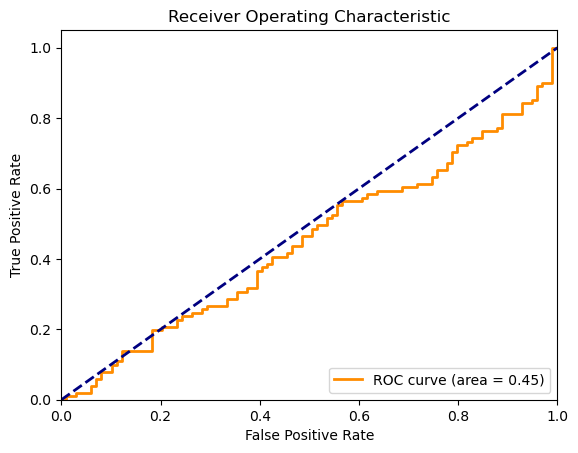

In [ ]:
# Create and evaluate a logistic regression model using the selected features to predict collapse risk

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = seismic_data[top_features]
y = seismic_data['collapse_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
from sklearn.metrics import roc_curve, auc
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Random Forest Regressor

In [39]:
# Random Forest Regressor Model to predict collapse probability

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = seismic_data[top_features]
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Squared Error: 919.6100033822543
R² Score: -0.025278292631035093


## SVR

In [40]:
# Support Vector Regressor (SVR) Model to predict collapse probability

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

X = seismic_data[top_features]
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')



Mean Squared Error: 1202.3625206771455
R² Score: -0.3405206422172766


In [45]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Scale features for SVR
scaler = StandardScaler()
X_scaled = scaler.fit_transform(seismic_data[top_features])
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'C': [50, 75, 100, 125, 150,],
    'gamma': [0.75, 1, 1.25, 1.5],
    'epsilon': [0.075, 0.1, 0.125],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Grid search
grid = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

# Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Best parameters: {'C': 75, 'epsilon': 0.075, 'gamma': 0.75, 'kernel': 'rbf'}
Mean Squared Error: 899.6231060728496
R² Score: -0.0029947899799007693


In [46]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(seismic_data[top_features])
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression Grid Search
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)
print("Best Ridge parameters:", ridge_grid.best_params_)
ridge_best = ridge_grid.best_estimator_
y_pred = ridge_best.predict(X_test)
print(f'Ridge MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Ridge R² Score: {r2_score(y_test, y_pred)}')

# Lasso Regression Grid Search
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train, y_train)
print("Best Lasso parameters:", lasso_grid.best_params_)
lasso_best = lasso_grid.best_estimator_
y_pred = lasso_best.predict(X_test)
print(f'Lasso MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Lasso R² Score: {r2_score(y_test, y_pred)}')

Best Ridge parameters: {'alpha': 100}
Ridge MSE: 931.6993863679594
Ridge R² Score: -0.03875681276561238
Best Lasso parameters: {'alpha': 10}
Lasso MSE: 900.009569035616
Lasso R² Score: -0.0034256596802877404


In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

X = seismic_data[top_features]
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best RF parameters:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
y_pred = rf_best.predict(X_test)
print(f'RF MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RF R² Score: {r2_score(y_test, y_pred)}')

Best RF parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
RF MSE: 909.3580005718087
RF R² Score: -0.013848277843371948
